In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore", message="Glyph 12 missing from current font.")



Data #1

In [112]:
data_polling = pd.read_stata("Data/cumulative_2006_2018.dta")

In [113]:
inputs = ['year','st','gender', 'age', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']
targets = ['pid3']

keep = inputs + targets

data_polling = data_polling[(data_polling.year == 2018) & (data_polling.pid3.isin(['Democrat','Republican']) )]

polling = data_polling[keep]

In [114]:
polling.dropna(axis=0, how='any',inplace=True)

In [115]:
pd.options.mode.chained_assignment = None  # default='warn'

polling['age_band'] = np.NaN
polling.loc[ (polling['age'] >= 18) & (polling['age'] <= 29), 'age_band'] = 'Young'
polling.loc[ (polling['age'] >= 30) & (polling['age'] <= 49), 'age_band'] = 'Lower-Middle'
polling.loc[ (polling['age'] >= 50) & (polling['age'] <= 69), 'age_band'] = 'Upper-Middle'
polling.loc[ (polling['age'] >= 70) , 'age_band'] = 'Old'

polling.loc[ polling['pid3'] == "Democrat", "Dem_Ind"] = 1
polling.loc[ polling['pid3'] == 'Republican', "Dem_Ind"] = 0
polling['Dem_Ind'] = polling['Dem_Ind'].astype(int)

categorical_polling = ['st','gender', 'age_band', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']

In [116]:
polling.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [117]:
small_polling = polling.sample(n=10000, random_state = 42)

X_polling = small_polling[categorical_polling]

y_polling = small_polling.loc[:,'Dem_Ind']

Data #2

In [118]:
# Originall Retrieved From: http://archive.ics.uci.edu/ml/datasets/Adult
# CSV Retrieved From: https://www.kaggle.com/uciml/adult-census-income
# URL: https://drive.google.com/file/d/1wuWJPeacMhHQSXdITZx1_pktoU-ZRb8n/view?usp=sharing
data_income = pd.read_csv("Data/adult.csv")

print(data_income.shape)

(32561, 15)


In [119]:
# Response Variable 
data_income.loc[ data_income['income'] == ">50K", "income"] = 1
data_income.loc[ data_income['income'] == '<=50K', "income"] = 0
data_income['income'] = data_income['income'].astype(int)

In [120]:
# Feature Engineering
data_income['native_USA'] = 0 
data_income.loc[ data_income['native.country'] == "United-States", "native_USA"] = 1
data_income.loc[ data_income['native.country'] != "United-States", "native_USA"] = 0

In [121]:
data_income['native_USA'].value_counts()

1    29170
0     3391
Name: native_USA, dtype: int64

In [122]:
data_income['age_band'] = np.NaN
data_income.loc[ (data_income['age'] <= 29), 'age_band'] = 'Young'
data_income.loc[ (data_income['age'] >= 30) & (data_income['age'] <= 49), 'age_band'] = 'Lower-Middle'
data_income.loc[ (data_income['age'] >= 50) & (data_income['age'] <= 69), 'age_band'] = 'Upper-Middle'
data_income.loc[ (data_income['age'] >= 70) , 'age_band'] = 'Old'

In [123]:
data_income['hours_band'] = np.NaN
data_income.loc[ (data_income['hours.per.week']) < 40, "hours_band"] = 'Low'
data_income.loc[ (data_income['hours.per.week']) == 40, "hours_band"] = 'Average'
data_income.loc[ (data_income['hours.per.week']) > 40, "hours_band"] = 'High'

In [124]:
data_income['hours_band'].value_counts()

Average    15217
High        9581
Low         7763
Name: hours_band, dtype: int64

In [125]:
categorical_income = ['workclass','education','marital.status','occupation','relationship','race','sex','native_USA','age_band','hours_band']


In [126]:
data_income['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [127]:
small_income = data_income.sample(10000,random_state=42)

In [128]:
X_income = small_income[categorical_income]

y_income = small_income.loc[:,'income']


General Use Functions

In [129]:
from sklearn.preprocessing import OneHotEncoder

def prep_data(X, y, categoricalVars):

    encoder = OneHotEncoder(sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricalVars]))
    X_encoded.columns = encoder.get_feature_names(categoricalVars)
    X.drop(categoricalVars, axis = 1, inplace = True)
    if X.shape[1] > 0:
        OH_X = pd.concat([X, pd.DataFrame(X_encoded, index=X.index)], axis = 1)
    else:
        OH_X = X_encoded 
        
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(OH_X, y, test_size = .30, train_size = .70, random_state = 42)
    return(X_Train, X_Test, Y_Train, Y_Test)

In [130]:
X_Train_Polling, X_Test_Polling, Y_Train_Polling, Y_Test_Polling = prep_data(X_polling, y_polling, categorical_polling)

In [131]:
X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income = prep_data(X_income, y_income, categorical_income)

### Tutorial for K-Means

Selecting the Number of clusters with silhouette analysis on KMeans Clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

- Silhoutte is a metric used to measure the separation distance between clusters 
- Silhoutte measure ranges from -1 to 1. 
- Silhoutte values near +1: good, sample is far from neighboring cluster
- Silhoutte values near 0: Samples is on or near the decision boundary between two clusters 
- Silhoutte values < 0: Bad, Samples may be assigned to wrong cluster 
- Vary the n_clusters and examine silhoutte metric 

In [132]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import numpy as np 

X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, center_box = (-10.0, 10.0), shuffle = True, random_state = 1)

print(X.shape)
print(y.shape)

(500, 2)
(500,)


In [133]:
range_n_clusters = [2, 3, 4, 5, 6]

For N clusters: 2 ,The Average silhouette score is : 0.7049787496083262
For N clusters: 3 ,The Average silhouette score is : 0.5882004012129721
For N clusters: 4 ,The Average silhouette score is : 0.6505186632729437
For N clusters: 5 ,The Average silhouette score is : 0.5745566973301872
For N clusters: 6 ,The Average silhouette score is : 0.4387644975296138


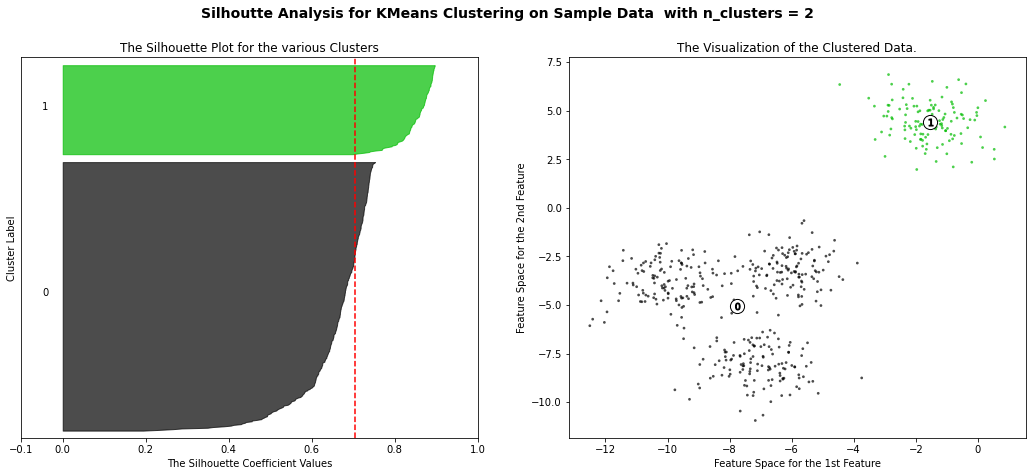

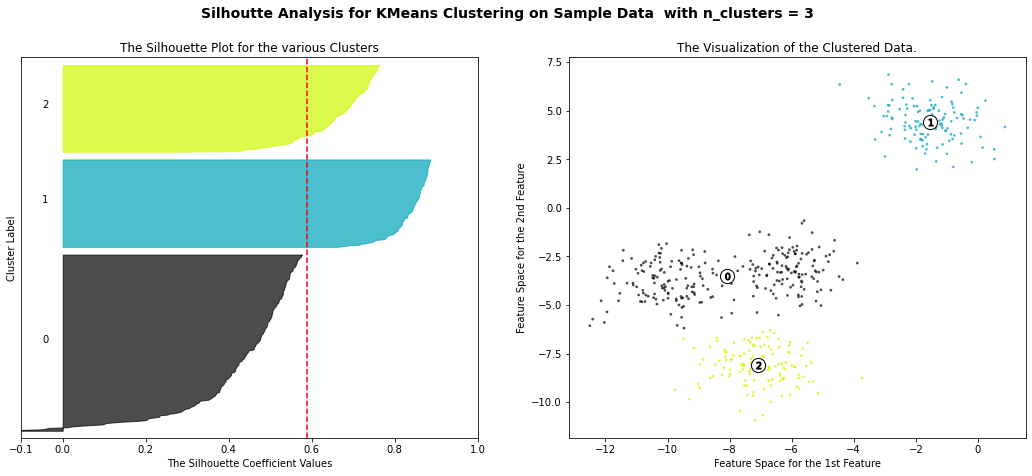

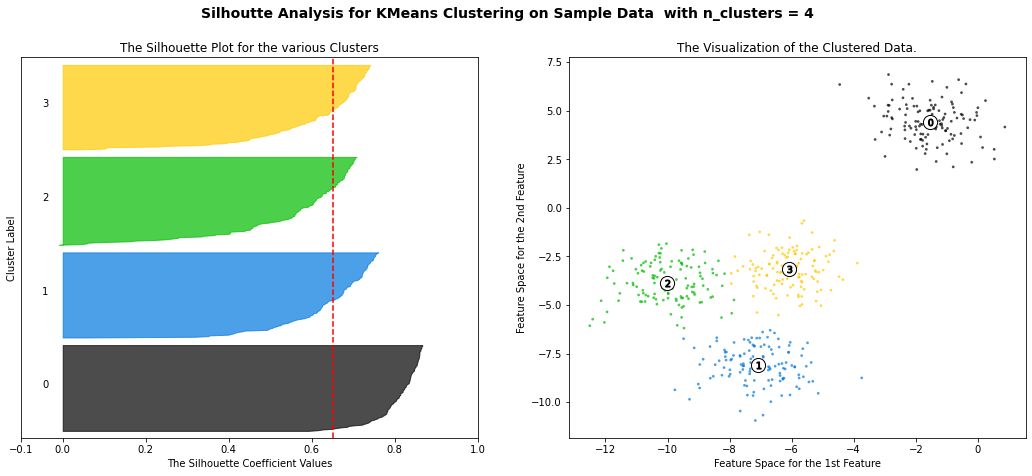

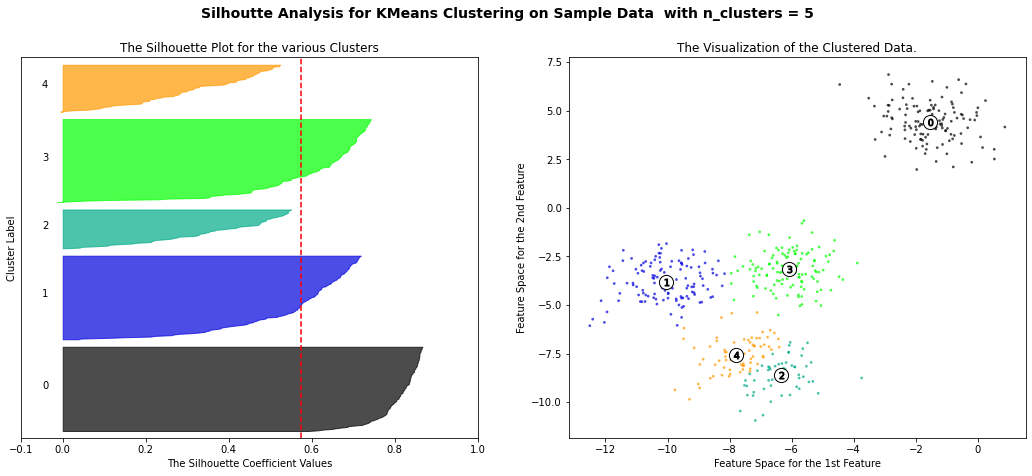

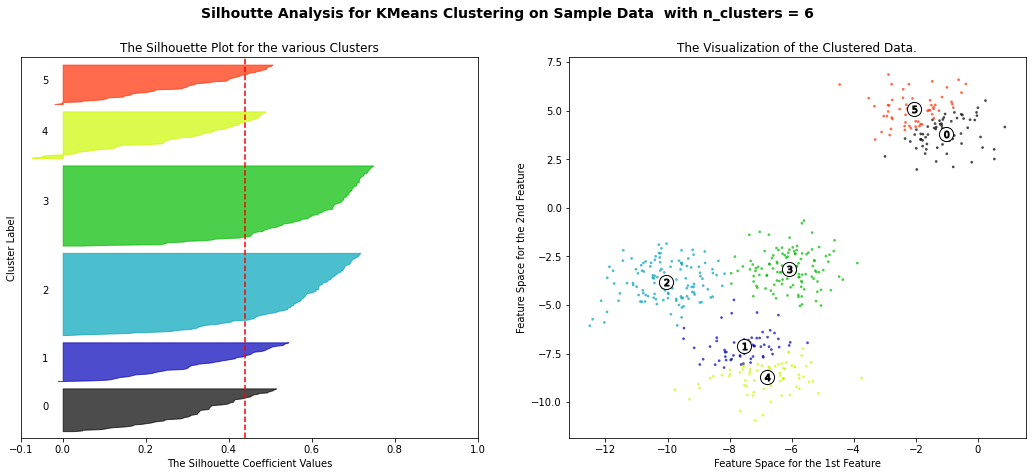

In [134]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Silhouette Plot 
    ax1.set_xlim([-.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1)*10])
    
    # initialize the clusterer with the n_clusters value 
    clusterer = KMeans(n_clusters=n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Silhouette_score gives avg value for all samples 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For N clusters:", n_clusters, ",The Average silhouette score is :", silhouette_avg)
    
    # Get Silhouette Scores for each sample 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate scores for samples in the ith cluster, and sort 
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                         facecolor = color, edgecolor = color, alpha = 0.7)
        
        # Label the silhouette plots with the cluster number in the middle 
        ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        
        # Computer the new y_lower for the next plot 
        y_lower = y_upper + 10 # Without this step, plots are all on top of each other 
        
    ax1.set_title("The Silhouette Plot for the various Clusters")
    ax1.set_xlabel("The Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    
    # The Vertical Line for avg. Silhouette Score of all the values 
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = "--")
    
    ax1.set_yticks([]) # Clear the Y Axis 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot shows the actual clusters formed 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker = ".", s=30, lw=0, alpha=0.7,
               c = colors, edgecolor = 'k')

    # Label the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers 
    ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o', 
               c = 'white', alpha = 1, s = 200, edgecolor = 'k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, 
                   s = 50, edgecolor = 'k')
    
    ax2.set_title("The Visualization of the Clustered Data.")
    ax2.set_xlabel("Feature Space for the 1st Feature")
    ax2.set_ylabel("Feature Space for the 2nd Feature")
    
    plt.suptitle(("Silhoutte Analysis for KMeans Clustering on Sample Data "
                    " with n_clusters = %d" %n_clusters),
                fontsize = 14, fontweight = 'bold')
    
    
plt.show()

#### Demo K-Means Clustering with MNIST Digits

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [135]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits = load_digits(return_X_y=True)

data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = n_digits

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
     % (n_digits, n_samples, n_features))

print(82 * '_')

print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    
    #print(estimator.inertia_) 
    #print(metrics.homogeneity_score(y_digits, estimator.labels_))
  
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
      % (name, (time() - t0), estimator.inertia_,
         metrics.homogeneity_score(y_digits, estimator.labels_),
         metrics.completeness_score(y_digits, estimator.labels_),
         metrics.v_measure_score(y_digits, estimator.labels_),
         metrics.adjusted_rand_score(y_digits, estimator.labels_),
         metrics.adjusted_mutual_info_score(y_digits,  estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_,
                                  metric='euclidean',
                                  sample_size=sample_size)))
    


bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.17s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.16s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.02s	70768	0.668	0.695	0.681	0.558	0.678	0.142
__________________________________________________________________________________


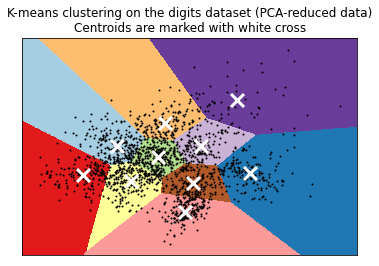

In [136]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Step 1

#### KMeans Data 1

In [137]:
X_Train_Polling.shape

(7000, 108)

In [138]:
range_num_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_num_clusters:
    kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)

    kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Train_Polling)

    # Silhouette_score gives avg value for all samples 
    kmeans_silhouette_avg = silhouette_score(X_Train_Polling, kmeans_cluster_labels)

    print("For N clusters:", n_clusters, ", Average silhouette score is :", kmeans_silhouette_avg, \
          ", Average inertia is :", kmeans_clusterer.inertia_)
    


For N clusters: 2 , Average silhouette score is : 0.07331336447494478 , Average inertia is : 45778.57030885092
For N clusters: 3 , Average silhouette score is : 0.06931835983425738 , Average inertia is : 43601.240520956344
For N clusters: 4 , Average silhouette score is : 0.06800304818421343 , Average inertia is : 42141.844130346675
For N clusters: 5 , Average silhouette score is : 0.06552256858749685 , Average inertia is : 40931.666277083066
For N clusters: 6 , Average silhouette score is : 0.06359700822605553 , Average inertia is : 40124.14832203976
For N clusters: 7 , Average silhouette score is : 0.0631561306847906 , Average inertia is : 39341.59188891309
For N clusters: 8 , Average silhouette score is : 0.06050658266747885 , Average inertia is : 38723.01545250349
For N clusters: 9 , Average silhouette score is : 0.05884938013158652 , Average inertia is : 38210.950046129175
For N clusters: 10 , Average silhouette score is : 0.060330742611182174 , Average inertia is : 37717.99772766

#### KMeans Data 2

In [139]:
X_Train_Income.shape

(7000, 69)

In [140]:
range_num_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
#range_num_clusters = np.arange(2, 25, 1)

for n_clusters in range_num_clusters:
    kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)

    kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Train_Income)

    # Silhouette_score gives avg value for all samples 
    kmeans_silhouette_avg = silhouette_score(X_Train_Polling, kmeans_cluster_labels)

    print("For N clusters:", n_clusters, ", Average silhouette score is :", kmeans_silhouette_avg, \
          ", Average inertia is :", kmeans_clusterer.inertia_)

For N clusters: 2 , Average silhouette score is : -7.048934840719281e-05 , Average inertia is : 34566.755556981225
For N clusters: 3 , Average silhouette score is : -0.000993558568090272 , Average inertia is : 32129.37373747313
For N clusters: 4 , Average silhouette score is : -0.0019629140634428747 , Average inertia is : 30695.43289851773
For N clusters: 5 , Average silhouette score is : -0.002573010330571771 , Average inertia is : 29493.822306518105
For N clusters: 6 , Average silhouette score is : -0.003469623084750927 , Average inertia is : 28733.097248083366
For N clusters: 7 , Average silhouette score is : -0.0042014268230241856 , Average inertia is : 28009.679347735713
For N clusters: 8 , Average silhouette score is : -0.006397141986538745 , Average inertia is : 27412.545538642382
For N clusters: 9 , Average silhouette score is : -0.006479075597232962 , Average inertia is : 26867.05776968403
For N clusters: 10 , Average silhouette score is : -0.008893968951124062 , Average inert

In [141]:
def kmeans_cluster(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        #print("For N clusters:", n_clusters, ", Average silhouette score is :", kmeans_silhouette_avg, \
        #      ", Average inertia is :", kmeans_clusterer.inertia_)
        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    plt.plot(n_clusters_list, inertia_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia (TSSE)")
    plt.title("The Effect of Number of Clusters \non Inertia for " + title)
    plt.show()
    #plt.savefig(title + "KMeans Inertia.png")
    
    plt.clf()
    plt.plot(n_clusters_list, avg_silhouette_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Average Silhouette Score")
    plt.title("The Effect of Number of Clusters \non Silhouette for " + title)
    plt.show()

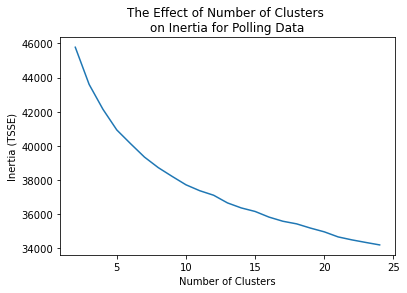

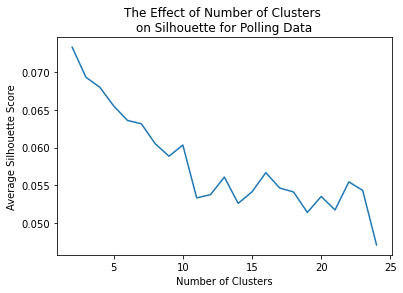

In [142]:
#kmeans_cluster(X_Train_Polling, [2, 3, 4, 5, 6, 7, 8, 9, 10], "Polling Data")
kmeans_cluster(X_Train_Polling, np.arange(2, 25, 1) , "Polling Data")


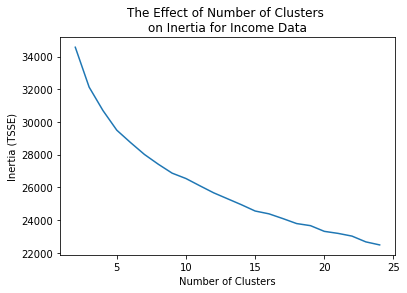

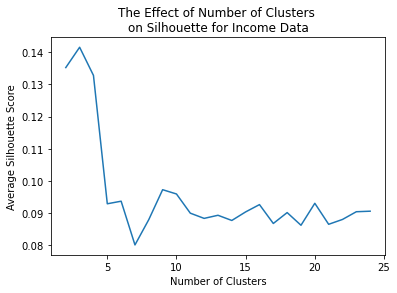

In [143]:
kmeans_cluster(X_Train_Income, np.arange(2, 25, 1) , "Income Data")


### EM Data 1

In [147]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    plt.clf()
    plt.plot(n_components_list, aic_list, label = 'AIC')
    plt.plot(n_components_list, bic_list, label = 'BIC')
    plt.legend()
    plt.xlabel("Number of Components")
    plt.ylabel("Metric Value")
    plt.title("The Effect of the Number of Components \non AIC/BIC for " + title + "\n With " + cov_type + " Covariance")
    plt.show()
    
    print("Silhouettes", avg_silhouette_list)
    
    plt.clf()
    plt.plot(n_components_list, avg_silhouette_list)
    plt.xlabel("Number of Components")
    plt.ylabel("Average Silhouette Score")
    plt.title("The Effect of Number of Components \non Silhouette for " + title + "\n With " + cov_type + " Covariance")
    plt.show()
    
    
        
    

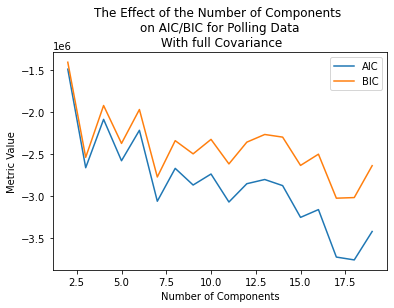

Silhouettes [0.07331336447494478, 0.00698613273306507, 0.051875038725606615, -0.011486348396113474, 0.0395297461686826, -0.006909155162600529, 0.02087705503523868, 0.030807207449398057, 0.04442399174619637, 0.005806846856362122, 0.02612208036996127, 0.01907532237477724, 0.03143621764790719, 0.01515624141556936, 0.004791346509599338, -0.017865590103383098, -0.01636469979595357, -0.001603202597543911]


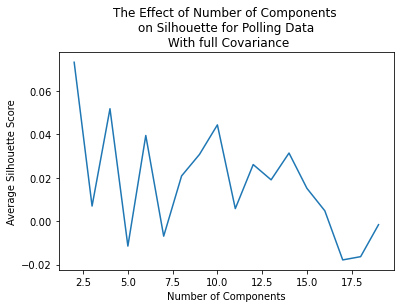

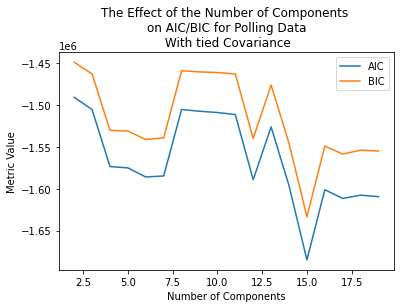

Silhouettes [0.07331336447494478, 0.06721996269174427, 0.061144973092727956, 0.05761510151333007, 0.049017821040354514, 0.05900880306291712, 0.05394549782333094, 0.05616219593945098, 0.05455892570962894, 0.05113524576640826, 0.04739678472316912, 0.04882186787949355, 0.051741714763422465, 0.0514479540990415, 0.038815191821625024, 0.039309557546586195, 0.036232231180831805, 0.039158647101756115]


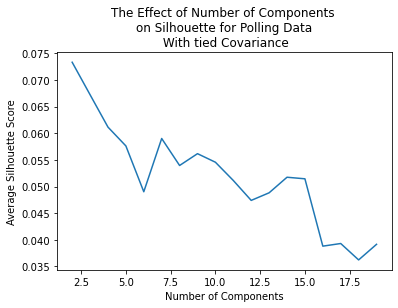

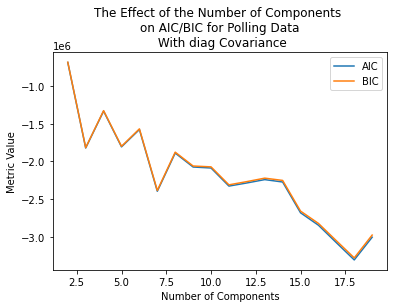

Silhouettes [0.07331336447494478, 0.03724345935510335, 0.05139313939082938, 0.0004928781304198222, 0.037907918902444965, 0.018272480677080438, 0.022731074923603573, 0.0341255237133546, 0.04370950181664999, 0.018416294748368242, 0.025374451806530588, 0.024349779398737736, 0.03169251058580869, 0.018988973678460624, 0.016941530714487323, -0.0013321921467002373, -0.00745860053538402, 0.0012698335041347148]


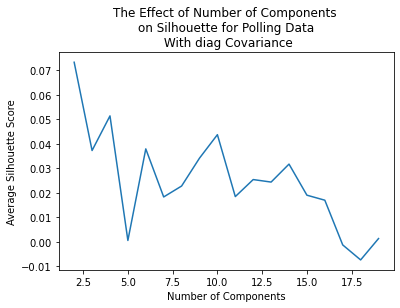

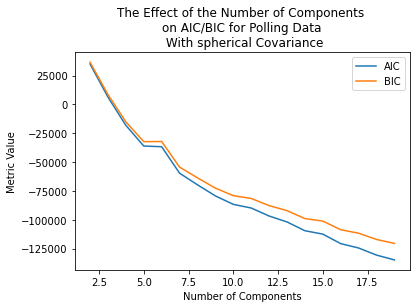

Silhouettes [0.07331336447494478, 0.06319487331299388, 0.05788294687195375, 0.05794035772127549, 0.054343712398820326, 0.05596353536647892, 0.05362456415826981, 0.04866371060659864, 0.05145438723053065, 0.046434166398708725, 0.043834215139829734, 0.04556236282355173, 0.05020698904350978, 0.040869167207301514, 0.040213613165958575, 0.03890615790370158, 0.044938132817007044, 0.04485670676258783]


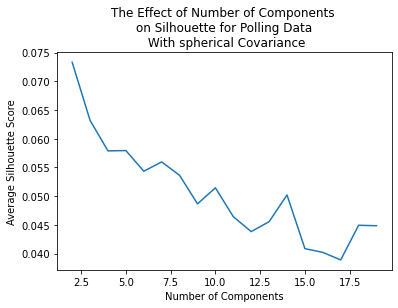

In [148]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Polling, np.arange(2, 20, 1), "Polling Data", cv)

Data 1:
- Silhouette Max score occurs for n_components = 2, for all cov_types, at 0.0733
- Highest Silhouette occurs for covariance type = Spherical, highest floor of 0.449 
- BIC/AIC elbow method occurs for n_components = 5, for Spherical, or 3 for others 

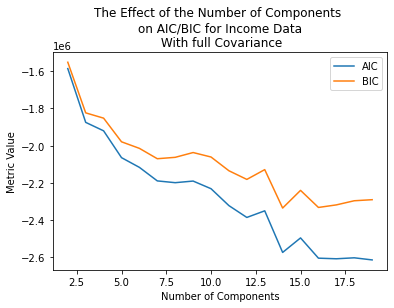

Silhouettes [0.13466498111857916, 0.13836092359564758, 0.08793029878531346, 0.07449548552431004, 0.05559578912520639, 0.0696418871081825, 0.0719009021993622, 0.07622484521388571, 0.07719048780923382, 0.07583011797204935, 0.0676358679689745, 0.07217684246711867, 0.0706457764619524, 0.08148968468868546, 0.06492725547332581, 0.07415930527298721, 0.06451834194331592, 0.06843830415526453]


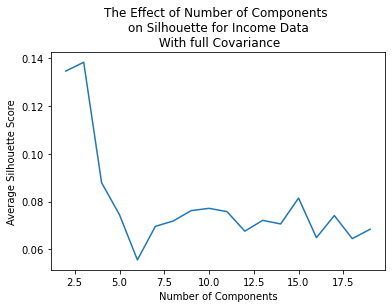

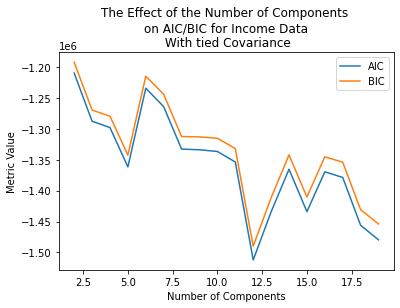

Silhouettes [0.13466498111857916, 0.14180683013810363, 0.08688430599492368, 0.08168459893983496, 0.07688809508269041, 0.07625062253123294, 0.08110905414230672, 0.08055831187923931, 0.07779972395498334, 0.08193202075677007, 0.09218553728477516, 0.08631477682390758, 0.07494092810241147, 0.08544466666748751, 0.06673471813736813, 0.08865013406361917, 0.0805279859752102, 0.09227953784360875]


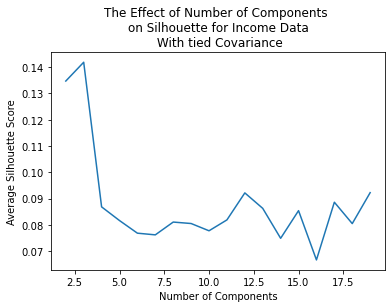

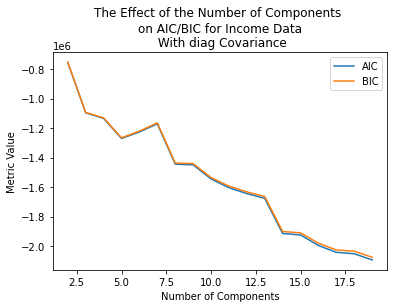

Silhouettes [0.13466498111857916, 0.14020677191000022, 0.09018733884680925, 0.0768417891854639, 0.05898306807801418, 0.07487323641414921, 0.08015193743112073, 0.07760232258075035, 0.07367240498353658, 0.07384601818803206, 0.0796725193096668, 0.07960017951468197, 0.07365748750464525, 0.08085718309545242, 0.06883531313764056, 0.07425137621506855, 0.07035544022925486, 0.06527648708112907]


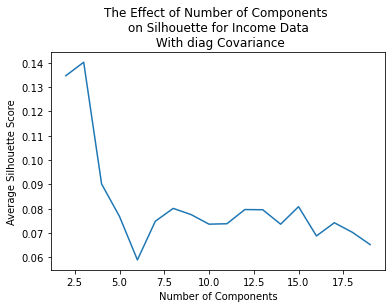

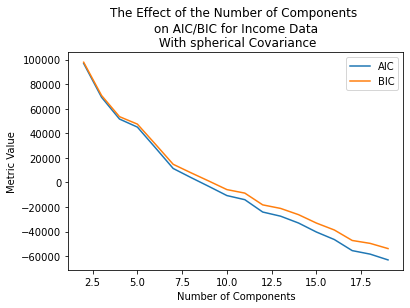

Silhouettes [0.1349776948405022, 0.14020683127411573, 0.08590614399764795, 0.07317888664953463, 0.06676861201494504, 0.07060364435543263, 0.07118010714643837, 0.07231452756456633, 0.06195595137881095, 0.06442353903687241, 0.07179948751058693, 0.06387123894435447, 0.05945573211563395, 0.06914225955482821, 0.04417714795022251, 0.04815904049228644, 0.04189682205107214, 0.04367816936578514]


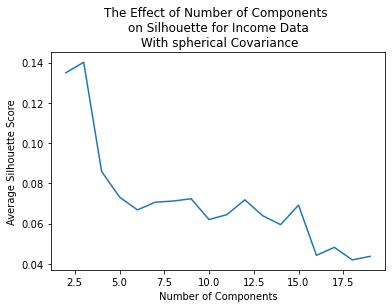

In [149]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Income, np.arange(2, 20, 1), "Income Data", cv)

Data 2:
- Silhouette Max score occurs for n_components = 3 at 0.142
- Highest Silhouette occurs for covariance type = 'tied'
- BIC/AIC elbow method occurs for n_components = 5, heuristic method shows where decrease slows down

## Step 2) Apply Dimensionality Reduction Algorithms to the Datasets

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

Implement 4 Dimensionality Reduction Algorithms on the 2 Data sets
- PCA: Principal Components Analysis
- ICA: Independent Components Analysis
- RCA: Random Components Analysis 
- TBD

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

### 2.1) PCA 

In [244]:
from sklearn.decomposition import PCA 

# No need to use Standard Scaler because we are using Binary Variables 

def run_PCA(X_Data, title):
    
    pca = PCA(n_components = .80, random_state = 42)
    pca.fit(X_Data)

    print("Optimal Number of Components:", pca.n_components_)
    max_feats = X_Data.shape[1]
    #max_feats = pca.n_components_

    plt.clf()
    #fig, (ax1, ax2) = plt.subplots(1,2)
    x = np.arange(1, pca.n_components_ +1)
    y1 = pca.explained_variance_ratio_.cumsum()
    plt.plot(x, y1)
    plt.plot(x, np.repeat(0.8, pca.n_components_), linestyle = '--', color = 'red')
    plt.ylabel("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.title("The Effect of Number of Components \non Cumulative Explained Variance \nfor "+ title)
    #ax1.set_title("The Effect of Number of Components \non Cumulative Explained Variance \nfor "+ title)
    plt.show()
    
    #print(pca.components_)
    #print(pca.singular_values_)
    
    y2 = pca.singular_values_
    plt.clf()
    plt.plot(x, y2)
    plt.xlabel("Number of Components")
    plt.ylabel("Eigenvalues")
    plt.title("The Effect of the Number of Components \non Eigenvalues for " + title)
    plt.show()

Optimal Number of Components: 31


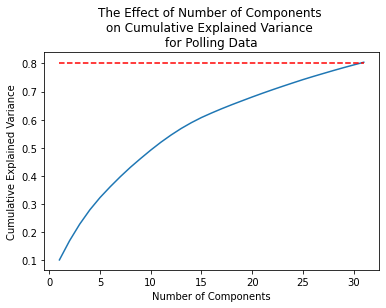

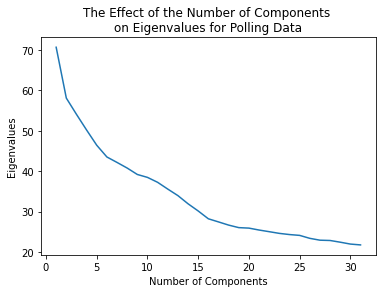

In [245]:
run_PCA(X_Train_Polling, "Polling Data")

Data #1
- Optimal Number of Components is 31

Optimal Number of Components: 19


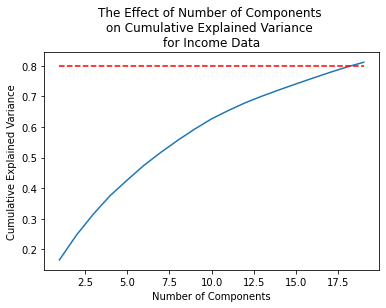

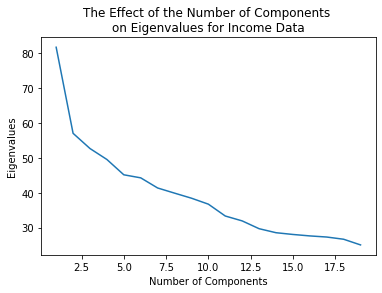

In [246]:
run_PCA(X_Train_Income, "Income Data")

Data #2
- Optimal Number of Components is 19

### 2.2) ICA

ICA chart modified from: https://github.com/kylewest520/CS-7641---Machine-Learning/blob/master/Assignment%203%20Unsupervised%20Learning/CS%207641%20HW3%20Code.ipynb

In [279]:
from sklearn.decomposition import FastICA as ICA 

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def run_ICA(X_Data,title):
    
    dims = list(np.arange(2,(X_Data.shape[1]-1),3))
    dims.append(X_Data.shape[1])
    ica = ICA(random_state=42)
    #ica = ICA(random_state=42, max_iter = 2000)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X_Data)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    print(kurt)
    plt.grid(False)
    plt.show()

[1.131709511472693, 1.3172585392254257, 1.2576556973485638, 1.2594495065390066, 1.401025370273739, 1.5335881607683024, 2.0032156327971036, 2.1957680627142087, 2.700947696293348, 3.1122080147734663, 3.5728913496237817, 4.448782957893588, 5.180730047578088, 6.0350038588746555, 6.926553437053599, 8.085106221176515, 9.2271303754392, 10.065874632317016, 11.83852443769082, 13.064778758270922, 15.053665207910665, 17.167888415678718, 18.597330326437095, 21.59530315708833, 24.703665816548494, 27.4319919632677, 31.67825419852508, 37.56367483440029, 44.27595190285211, 52.69697169339922, 61.88348439161119, 77.7895481610112, 94.94879791206175, 82.30110862134677, 77.15235388265702, 63.336563600170706]


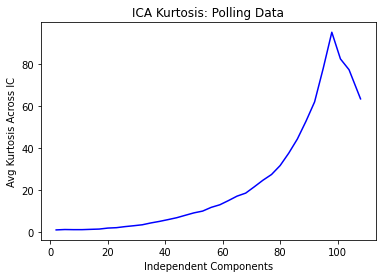

40.79242300987244


In [280]:
start = time.time()

run_ICA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- When number of IC components = 29, that is when Kurtosis > 3
- Kurtosis = 3 when a distribution is Normally Distributed
- Kurtosis >> 3 implies that there is a lot of weight in the tails of a distribution, measures many outliers
- ICA did not converge, even with 2000 max iterations, but values did not change by increasing 

[0.8101149071454676, 1.1853864281489916, 1.3316357883983336, 1.5030991859542049, 1.6141219504239088, 1.795701971254792, 2.484155055608634, 2.9973053038700863, 4.0114533996336315, 5.086835247150425, 6.611410539008532, 8.624708339885512, 10.494488050320385, 12.732291191578117, 15.318614651555434, 19.034179379114143, 25.345286844719165, 33.13832354639053, 114.16543729146989, 226.09335304054173, 231.92295451862014, 189.37655647772468, 130.03544805347104]


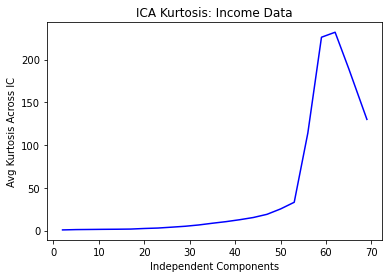

12.014431238174438


In [281]:
start = time.time()

run_ICA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Kurtosis stays much lower in this dataset through around 55 independent components, but then it shoots up over 200 kurtosis, which is much higher than Dataset 1 
- When number of IC equals 23, the Kurtosis Exceeds a value of 3

### 2.3) RCA 

In [298]:
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.metrics.pairwise import pairwise_distances

max_feats = X_Train_Polling.shape[1]

grp = GRP(random_state = 42, n_components = max_feats)
grp.fit(X_Train_Polling)

X_Train_Recon = pairwise_distances(grp.fit_transform(X_Train_Polling))
X_Train = pairwise_distances(X_Train_Polling)

np.corrcoef(X_Train_Recon.ravel(), X_Train.ravel())[0, 1]

0.8480440236139417

In [307]:
from collections import defaultdict
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from itertools import product

def run_RCA(X,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    # Run RCA 5 Times, and get the Average Reconstruction Correlation
    for i,dim in product(range(5),dims):
        
        rca = RCA(random_state=i, n_components=dim)
        
        X_Train_Recon = pairwise_distances(rca.fit_transform(X_Train_Polling))
        X_Train = pairwise_distances(X_Train_Polling)
        
        tmp[dim][i] = np.corrcoef(X_Train_Recon.ravel(), X_Train.ravel())[0, 1]
        #print(tmp[dim][i])
        
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()

    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()

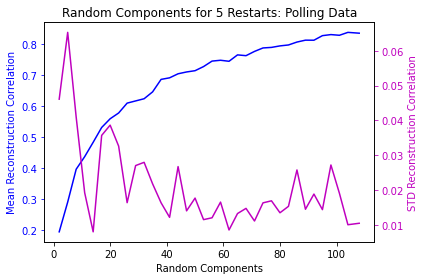

In [308]:
run_RCA(X_Train_Polling, "Polling Data")

- Data1 has a good Mean and lower standard deviation once we have more than 40 components in the model 

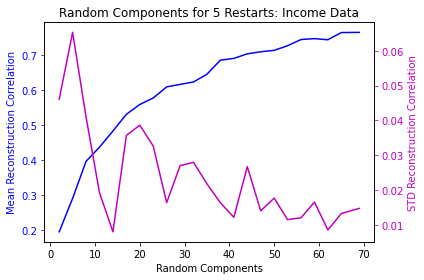

In [309]:
run_RCA(X_Train_Income, "Income Data")

### Step 2.4) Random Forest Classifier

We can use Y in this Dimensionality Reduction Algorithm

In [327]:
from sklearn.ensemble import RandomForestClassifier as RFC

#def run_RFC(X, y, df_original):
def run_RFC(X_Data, Y_Data):
    
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X_Data)*.01),random_state=5,n_jobs=-1)
    importances = rfc.fit(X_Data, Y_Data).feature_importances_ 
    
    importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
    importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Feature Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    top_cols = importances.index.tolist()
    
    return (importances, top_cols)

In [334]:
importances, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling)

print(importances.shape)

importances

(10, 2)


,Feature Importance,Cum Sum
approval_pres_Strongly Disapprove,0.351210,0.351210
approval_pres_Strongly Approve,0.224122,0.575332
economy_retro_Gotten Much Better,0.118209,0.693541
approval_pres_Approve / Somewhat Approve,0.072310,0.765851
economy_retro_Stayed About The Same,0.049730,0.815581
economy_retro_Gotten Worse / Somewhat Worse,0.040886,0.856467
race_White,0.030250,0.886717
economy_retro_Gotten Better / Somewhat Better,0.026144,0.912861
race_Black,0.020218,0.933079
economy_retro_Gotten Much Worse,0.012364,0.945442


- Dataset #1 Only requires 10 features to explain 95% of the results, using Random Forest Classifer 

In [333]:
importances, top_cols  = run_RFC(X_Train_Income, Y_Train_Income)

print(importances.shape)

importances

(19, 2)


,Feature Importance,Cum Sum
marital.status_Married-civ-spouse,0.211116,0.211116
relationship_Husband,0.154362,0.365477
age_band_Young,0.083861,0.449338
marital.status_Never-married,0.079992,0.529330
hours_band_High,0.055822,0.585152
occupation_Exec-managerial,0.054222,0.639374
occupation_Prof-specialty,0.041457,0.680831
education_Bachelors,0.036815,0.717646
sex_Female,0.028026,0.745672
education_HS-grad,0.027024,0.772696


- Dataset #2, only Needs 19 components to get 95% of the feature importance using Random Forest Classifier